### Importing the libraries that will be used in the model

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Synthetic over sampling of minority
from imblearn.over_sampling import SMOTE

# Complexity
from datetime import datetime

# Visualization
import matplotlib.pyplot as plt
import seaborn as sbn
%matplotlib inline

# Algorithms
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier 
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
import xgboost as xgb
from sklearn.ensemble import BaggingClassifier
from catboost import CatBoostClassifier

# Training
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

# Evaluating
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score, precision_score, recall_score

### Loading the dataset into a pandas dataframe

In [2]:
df = pd.read_csv("/Users/yadushyadav/downloads/healthcare-stroke/train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
id                   43400 non-null int64
gender               43400 non-null object
age                  43400 non-null float64
hypertension         43400 non-null int64
heart_disease        43400 non-null int64
ever_married         43400 non-null object
work_type            43400 non-null object
Residence_type       43400 non-null object
avg_glucose_level    43400 non-null float64
bmi                  41938 non-null float64
smoking_status       30108 non-null object
stroke               43400 non-null int64
dtypes: float64(3), int64(4), object(5)
memory usage: 4.0+ MB


### Viewing the dataset and fixing irregularities

In [3]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


In [4]:
df['smoking_status'].value_counts()

never smoked       16053
formerly smoked     7493
smokes              6562
Name: smoking_status, dtype: int64

In [5]:
df['stroke'].value_counts()

0    42617
1      783
Name: stroke, dtype: int64

In [6]:
df['gender'].value_counts()

Female    25665
Male      17724
Other        11
Name: gender, dtype: int64

In [7]:
print(df[["gender", "stroke"]].groupby(['gender'], as_index=False).mean())

   gender    stroke
0  Female  0.016793
1    Male  0.019860
2   Other  0.000000


In [8]:
df['gender'] = df['gender'].map({'Female': 0, 'Male': 1, 'Other': 2} ).astype(int)

In [9]:
df['Residence_type'].value_counts()

Urban    21756
Rural    21644
Name: Residence_type, dtype: int64

In [10]:
df['Residence_type'] = df['Residence_type'].map({'Urban': 0, 'Rural': 1} ).astype(int)

In [11]:
df['ever_married'].value_counts()

Yes    27938
No     15462
Name: ever_married, dtype: int64

In [12]:
df['ever_married'] = df['ever_married'].map({'Yes': 0, 'No': 1} ).astype(int)

In [13]:
df['work_type'].value_counts()

Private          24834
Self-employed     6793
children          6156
Govt_job          5440
Never_worked       177
Name: work_type, dtype: int64

In [14]:
df['work_type'] = df['work_type'].map({'Private': 0, 'Self-employed': 1, 'children': 2, 'Govt_job': 3, 'Never_worked': 4} ).astype(int)

In [15]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,1,3.0,0,0,1,2,1,95.12,18.0,NaN,0
1,30468,1,58.0,1,0,0,0,0,87.96,39.2,never smoked,0
2,16523,0,8.0,0,0,1,0,0,110.89,17.6,NaN,0
3,56543,0,70.0,0,0,0,0,1,69.04,35.9,formerly smoked,0
4,46136,1,14.0,0,0,1,4,1,161.28,19.1,NaN,0


In [16]:
print(sum(pd.isnull(df['smoking_status']))/df.shape[0])

0.3062672811059908


30% of smoking_status values are NaN

Finding correlation between smoking_status and other parameters

In [17]:
temp = df[df['smoking_status'].isnull()==False]

In [18]:
temp.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,30468,1,58.0,1,0,0,0,0,87.96,39.2,never smoked,0
3,56543,0,70.0,0,0,0,0,1,69.04,35.9,formerly smoked,0
6,52800,0,52.0,0,0,0,0,0,77.59,17.7,formerly smoked,0
7,41413,0,75.0,0,1,0,1,1,243.53,27.0,never smoked,0
8,15266,0,32.0,0,0,0,0,1,77.67,32.3,smokes,0


In [19]:
temp['smoking_status'].value_counts()

never smoked       16053
formerly smoked     7493
smokes              6562
Name: smoking_status, dtype: int64

In [20]:
temp['smoking_status'] = temp['smoking_status'].map({'never smoked': 0, 'formerly smoked': 1, 'smokes': 2} ).astype(int)

/Users/yadushyadav/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### Correlation between all the parameters

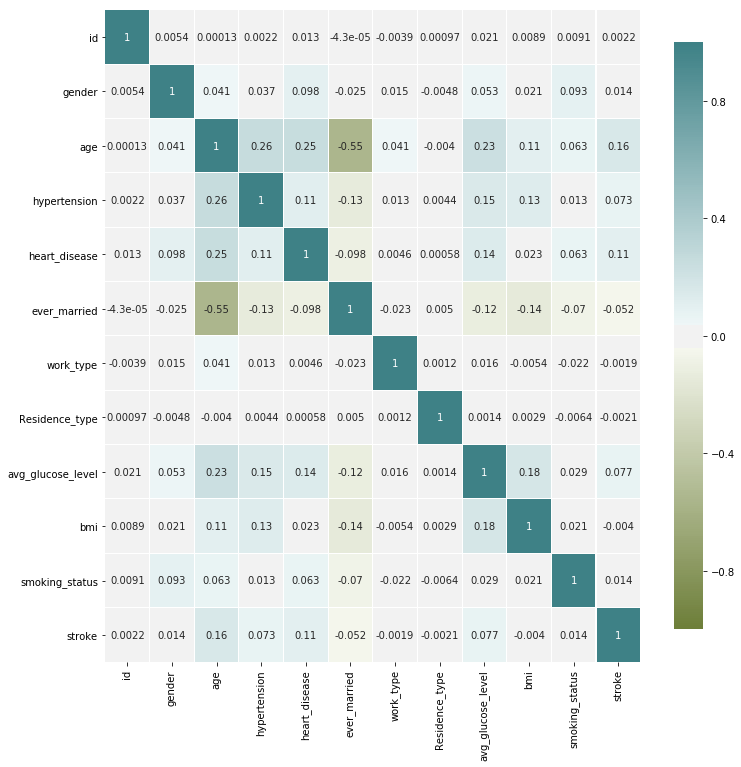

In [21]:
def corrmap(df):
    fig , ax = plt.subplots(figsize =(12, 12))
    fig = sbn.heatmap(df.corr(), cmap = sbn.diverging_palette(100, 200, as_cmap = True), cbar_kws={'shrink':.9 }, ax=ax,annot=True, linewidths=0.05, vmin=-1.0, vmax=1.0, linecolor='white')

corrmap(temp)

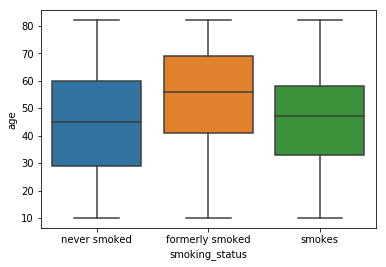

In [22]:
sbn.boxplot(df['smoking_status'],df['age'])

In [23]:
temp = df

The age of the oldest person

In [24]:
temp['age'].max()

82.0

Dividing the age into categories with an interval of 10 years

In [25]:
def ageconv(x):
    if x<=10:
        return 0
    if x<=20:
        return 1
    if x<=30:
        return 2  
    if x<=40:
        return 3
    if x<=50:
        return 4
    if x<=60:
        return 5
    if x<=70:
        return 6
    if x<=80:
        return 7
    if x<=90:
        return 8
    
temp['agecat'] = df['age'].apply(lambda x: ageconv(x))

In [26]:
temp['agecat'].value_counts()

5    6691
4    6441
3    5521
6    5229
2    5221
0    4598
1    4417
7    4393
8     889
Name: agecat, dtype: int64

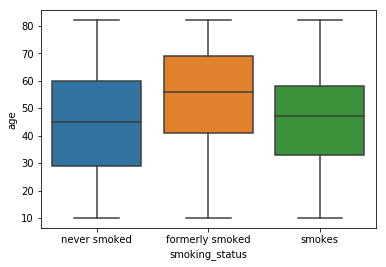

In [27]:
sbn.boxplot(temp['smoking_status'],temp['age'])

Using the boxplot, it can be seen that people less than 20 years old are unlikely to be smokers

The NaN and value counts for ages less than multiple of 10s

In [28]:
for x in range(10,100,10):
    print("Age less than",x)
    temp = df[df['age']<x]
    print("NaN values:",temp['smoking_status'].isnull().sum(axis=0))
    print(temp['smoking_status'].value_counts(),"\n")

Age less than 10
NaN values: 4285
Series([], Name: smoking_status, dtype: int64) 

Age less than 20
NaN values: 6444
never smoked       1621
formerly smoked     269
smokes              177
Name: smoking_status, dtype: int64 

Age less than 30
NaN values: 7529
never smoked       4017
smokes             1247
formerly smoked     918
Name: smoking_status, dtype: int64 

Age less than 40
NaN values: 8668
never smoked       6441
smokes             2366
formerly smoked    1708
Name: smoking_status, dtype: int64 

Age less than 50
NaN values: 9894
never smoked       9156
smokes             3702
formerly smoked    2752
Name: smoking_status, dtype: int64 

Age less than 60
NaN values: 11153
never smoked       11857
smokes              5057
formerly smoked     4206
Name: smoking_status, dtype: int64 

Age less than 70
NaN values: 12158
never smoked       13865
smokes              5936
formerly smoked     5713
Name: smoking_status, dtype: int64 

Age less than 80
NaN values: 13002
never smoked    

From the boxplot, all the people less than 20 years old whose smoking_status is NaN, can be filled as 'never smoked'

In [29]:
def fillsmoking(x):
    if pd.isnull(x['smoking_status']):
        if x['age']<20:
            x['smoking_status'] = "never smoked"
    return x

df = df.apply(lambda x : fillsmoking(x),axis=1)
df.head()    

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,agecat
0,30669,1,3.0,0,0,1,2,1,95.12,18.0,never smoked,0,0
1,30468,1,58.0,1,0,0,0,0,87.96,39.2,never smoked,0,5
2,16523,0,8.0,0,0,1,0,0,110.89,17.6,never smoked,0,0
3,56543,0,70.0,0,0,0,0,1,69.04,35.9,formerly smoked,0,6
4,46136,1,14.0,0,0,1,4,1,161.28,19.1,never smoked,0,1


In [30]:
df['smoking_status'] = df['smoking_status'].fillna('unknown')
df['smoking_status'].value_counts()

never smoked       22497
formerly smoked     7493
unknown             6848
smokes              6562
Name: smoking_status, dtype: int64

In [31]:
df['smoking_status'] = df['smoking_status'].map({'never smoked': 0, 'formerly smoked': 1, 'smokes': 2, 'unknown': 3} ).astype(int)

Unknown can be dropped later on if found to be of low importance

In [32]:
df['smoking_status'].value_counts()

0    22497
1     7493
3     6848
2     6562
Name: smoking_status, dtype: int64

In [33]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,agecat
0,30669,1,3.0,0,0,1,2,1,95.12,18.0,0,0,0
1,30468,1,58.0,1,0,0,0,0,87.96,39.2,0,0,5
2,16523,0,8.0,0,0,1,0,0,110.89,17.6,0,0,0
3,56543,0,70.0,0,0,0,0,1,69.04,35.9,1,0,6
4,46136,1,14.0,0,0,1,4,1,161.28,19.1,0,0,1


In [34]:
print("Unique ID's : ", len(df['id'].unique()))

Unique ID's :  43400


Since, 'id' is unique for everyone, it won't be useful in classification and can be dropped

In [35]:
df.drop('id',axis=1,inplace=True)

In [36]:
df.describe()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,agecat
count,43400.000000,43400.000000,43400.000000,43400.000000,43400.000000,43400.000000,43400.000000,43400.000000,41938.000000,43400.000000,43400.000000,43400.000000
mean,0.408894,42.217894,0.093571,0.047512,0.356267,0.832558,0.498710,104.482750,28.605038,0.948410,0.018041,3.683825
std,0.492151,22.519649,0.291235,0.212733,0.478901,1.106406,0.500004,43.111751,7.770020,1.139334,0.133103,2.234833
min,0.000000,0.080000,0.000000,0.000000,0.000000,0.000000,0.000000,55.000000,10.100000,0.000000,0.000000,0.000000
25%,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,77.540000,23.200000,0.000000,0.000000,2.000000
50%,0.000000,44.000000,0.000000,0.000000,0.000000,0.000000,0.000000,91.580000,27.700000,0.000000,0.000000,4.000000
75%,1.000000,60.000000,0.000000,0.000000,1.000000,2.000000,1.000000,112.070000,32.900000,2.000000,0.000000,5.000000
max,2.000000,82.000000,1.000000,1.000000,1.000000,4.000000,1.000000,291.050000,97.600000,3.000000,1.000000,8.000000


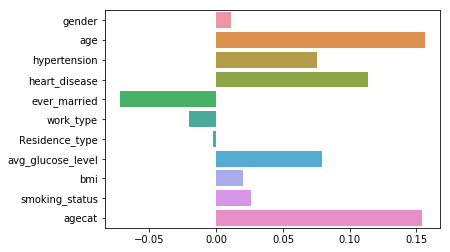

In [37]:
x = df.columns
x = x.drop('stroke')
arr = []
for c in x:
    arr.append(df['stroke'].corr(df[c]))
    
sbn.barplot(arr,x)

In [38]:
print(pd.crosstab(df['smoking_status'],df['stroke']))

stroke              0    1
smoking_status            
0               22211  286
1                7272  221
2                6429  133
3                6705  143


In [39]:
print(len(df[df['stroke']==1])/df.shape[0])

0.01804147465437788


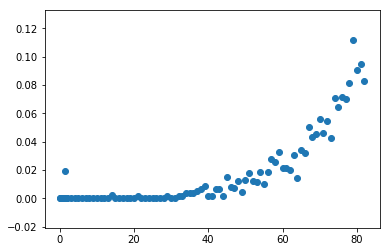

In [40]:
temp = df.pivot_table(index=df['age'],values='stroke',aggfunc=('mean','count'))
plt.scatter(temp.index,temp['mean'])
plt.show()

The probability of suffering a stroke increases with age

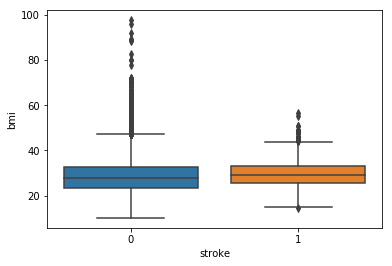

In [41]:
sbn.boxplot(df['stroke'],df['bmi'])

The probability of suffering a stroke increases with BMI (Body Mass Index)

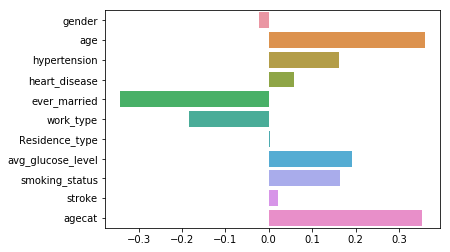

In [42]:
z = df.columns
z = z.drop('bmi')
arr = []
for c in z:
    arr.append(df['bmi'].corr(df[c]))
sbn.barplot(arr,z)

This barplot shows the correlation of BMI with other parameters

In [43]:
print("Median: ",df['bmi'].median())
print("Mean: ",df['bmi'].mean())

Median:  27.7
Mean:  28.605038390004545


In [44]:
df['bmi'].fillna(27.7,inplace=True)

In [45]:
temp = df
x = temp.columns
x = x.drop('stroke')

### Synthetic Minority Oversampling is done to increase the number of minority class data rows by adding artificial samples

In [46]:
sm = SMOTE(random_state=12, ratio = 0.6)
x_train_res, y_train_res = sm.fit_sample(temp[x], temp['stroke'])
temp = x_train_res
#temp.head()
result = pd.DataFrame(columns=x,data=temp)
result['stroke']=y_train_res
result.shape

/Users/yadushyadav/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


(68187, 12)

In [47]:
len(result[result['stroke']==1])/result.shape[0]

0.3749981668059894

The minority class is present in 37.4% of all data rows now

In [48]:
reserved_df = df

Saved the dataframe in reserved_df incase of any changes 

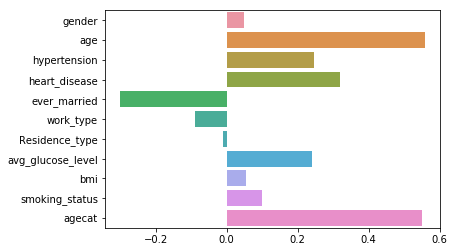

In [49]:
# Correlation between 'stroke' and the other parameters

df = result
x = df.columns
x = x.drop('stroke')
arr = []
for c in x:
    arr.append(df['stroke'].corr(df[c]))
sbn.barplot(arr,x)

In [50]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,agecat,stroke
0,1.0,3.0,0.0,0.0,1.0,2.0,1.0,95.12,18.0,0.0,0.0,0
1,1.0,58.0,1.0,0.0,0.0,0.0,0.0,87.96,39.2,0.0,5.0,0
2,0.0,8.0,0.0,0.0,1.0,0.0,0.0,110.89,17.6,0.0,0.0,0
3,0.0,70.0,0.0,0.0,0.0,0.0,1.0,69.04,35.9,1.0,6.0,0
4,1.0,14.0,0.0,0.0,1.0,4.0,1.0,161.28,19.1,0.0,1.0,0


In [51]:
# Resampling

df = df.sample(frac=1).reset_index(drop=True)

In [52]:
cols = df.columns
cols = cols.drop('stroke')
x = df[cols]
y = df['stroke']

In [53]:
kf = KFold(n_splits=5)

In [54]:
# KFold cross validation to optimize the parameters
# Stratified KFold cross validation can also be used

r = []

for train_index, test_index in kf.split(df):
    xtrain, xtest = x.iloc[train_index], x.iloc[test_index]
    ytrain, ytest = y[train_index], y[test_index]
    model = RandomForestClassifier()
    model.fit(xtrain,ytrain)
    pred = model.predict(xtest)
    r.append(f1_score(pred,ytest))

c=0   
for i in ytest:
    if i==1:
        c+=1
        
print(c/len(ytest))
print(np.mean(r))

0.3751558260614505
0.9824664891724236


In [55]:
cols = cols.drop('agecat')

In [56]:
xtrain,xtest,ytrain,ytest = train_test_split(df[cols],df['stroke'],test_size=0.2,random_state=0)

In [57]:
d = []
f = []
r = []
p = []
n = []
t = []

In [58]:
time1 = datetime.now()

model = LogisticRegression()
model.fit(xtrain,ytrain)
pred1 = model.predict(xtest)

time2 = datetime.now()

t.append((time2-time1).total_seconds())

d.append(roc_auc_score(pred1,ytest))
f.append(f1_score(pred1,ytest))
p.append(precision_score(pred1,ytest))
r.append(recall_score(pred1,ytest))

n.append('LogisticRegression')

print(time2-time1)

0:00:00.474733


In [59]:
time1 = datetime.now()

model = SGDClassifier()
model.fit(xtrain,ytrain)
pred2 = model.predict(xtest)

time2 = datetime.now()

t.append((time2-time1).total_seconds())

d.append(roc_auc_score(pred2,ytest))
f.append(f1_score(pred2,ytest))
p.append(precision_score(pred2,ytest))
r.append(recall_score(pred2,ytest))

n.append('SGDClassifier')

print(time2-time1)

0:00:00.085121


/Users/yadushyadav/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [60]:
time1 = datetime.now()

model = RandomForestClassifier()
model.fit(xtrain,ytrain)
pred3 = model.predict(xtest)

time2 = datetime.now()

t.append((time2-time1).total_seconds())

d.append(roc_auc_score(pred3,ytest))
f.append(f1_score(pred3,ytest))
p.append(precision_score(pred3,ytest))
r.append(recall_score(pred3,ytest))

n.append('RandomForestClassifier')

print(time2-time1)

0:00:00.909630


In [61]:
#time1 = datetime.now()
#model = GaussianProcessClassifier()
#model.fit(xtrain,ytrain)
#pred5 = model.predict(xtest)
#time2 = datetime.now()
#t.append(time2-time1)
#d.append(roc_auc_score(pred5,ytest))
#n.append('GaussianProcessClassifier')
#print(time2-time1)

In [62]:
time1 = datetime.now()

model = DecisionTreeClassifier()
model.fit(xtrain,ytrain)
pred6 = model.predict(xtest)

time2 = datetime.now()

t.append((time2-time1).total_seconds())

d.append(roc_auc_score(pred6,ytest))
f.append(f1_score(pred6,ytest))
p.append(precision_score(pred6,ytest))
r.append(recall_score(pred6,ytest))

n.append('DecisionTreeClassifier')

print(time2-time1)

0:00:00.278716


In [63]:
time1 = datetime.now()

model = AdaBoostClassifier()
model.fit(xtrain,ytrain)
pred7 = model.predict(xtest)

time2 = datetime.now()

t.append((time2-time1).total_seconds())

f.append(f1_score(pred7,ytest))
p.append(precision_score(pred7,ytest))
r.append(recall_score(pred7,ytest))
d.append(roc_auc_score(pred7,ytest))

n.append('AdaBoostClassifier')

print(time2-time1)

0:00:02.754859


In [64]:
time1 = datetime.now()

model = GaussianNB()
model.fit(xtrain,ytrain)
pred8 = model.predict(xtest)

time2 = datetime.now()

t.append((time2-time1).total_seconds())

f.append(f1_score(pred8,ytest))
p.append(precision_score(pred8,ytest))
r.append(recall_score(pred8,ytest))
d.append(roc_auc_score(pred8,ytest))

n.append('GaussianN')

print(time2-time1)

0:00:00.041048


In [65]:
time1 = datetime.now()

model = QuadraticDiscriminantAnalysis()
model.fit(xtrain,ytrain)
pred9 = model.predict(xtest)

time2 = datetime.now()

t.append((time2-time1).total_seconds())

d.append(roc_auc_score(pred9,ytest))
f.append(f1_score(pred9,ytest))
p.append(precision_score(pred9,ytest))
r.append(recall_score(pred9,ytest))

n.append('QuadraticDiscriminantAnalysis')

print(time2-time1)

0:00:00.069189


In [66]:
time1 = datetime.now()

model = MLPClassifier()
model.fit(xtrain,ytrain)
pred10 = model.predict(xtest)

time2 = datetime.now()

t.append((time2-time1).total_seconds())

d.append(roc_auc_score(pred10,ytest))
f.append(f1_score(pred10,ytest))
p.append(precision_score(pred10,ytest))
r.append(recall_score(pred10,ytest))

n.append('MLPClassifier')

print(time2-time1)

0:00:04.074929


In [67]:
time1 = datetime.now()

model = KNeighborsClassifier()
model.fit(xtrain,ytrain)
pred11 = model.predict(xtest)

time2 = datetime.now()

t.append((time2-time1).total_seconds())

d.append(roc_auc_score(pred11,ytest))
f.append(f1_score(pred11,ytest))
p.append(precision_score(pred11,ytest))
r.append(recall_score(pred11,ytest))

n.append('KNeighborsClassifier')

print(time2-time1)

0:00:00.489088


In [68]:
time1 = datetime.now()

model = GradientBoostingClassifier()
model.fit(xtrain,ytrain)
pred12 = model.predict(xtest)

time2 = datetime.now()

t.append((time2-time1).total_seconds())

d.append(roc_auc_score(pred12,ytest))
f.append(f1_score(pred12,ytest))
p.append(precision_score(pred12,ytest))
r.append(recall_score(pred12,ytest))

n.append('GradientBoostingClassifier')

print(time2-time1)

0:00:06.121660


In [69]:
time1 = datetime.now()

model = ExtraTreesClassifier()
model.fit(xtrain,ytrain)
pred13 = model.predict(xtest)

time2 = datetime.now()

t.append((time2-time1).total_seconds())

d.append(roc_auc_score(pred13,ytest))
f.append(f1_score(pred13,ytest))
p.append(precision_score(pred13,ytest))
r.append(recall_score(pred13,ytest))

n.append('ExtraTreesClassifier')

print(time2-time1)

0:00:00.507514


In [70]:
time1 = datetime.now()

model = BaggingClassifier()
model.fit(xtrain,ytrain)
pred15 = model.predict(xtest)

time2 = datetime.now()

t.append((time2-time1).total_seconds())

d.append(roc_auc_score(pred15,ytest))
f.append(f1_score(pred15,ytest))
p.append(precision_score(pred15,ytest))
r.append(recall_score(pred15,ytest))

n.append('BaggingClassifier')

print(time2-time1)

0:00:01.573886


In [71]:
time1 = datetime.now()

model = xgb.XGBClassifier()
model.fit(xtrain,ytrain)
pred16 = model.predict(xtest)

time2 = datetime.now()

t.append((time2-time1).total_seconds())

d.append(roc_auc_score(pred16,ytest))
f.append(f1_score(pred16,ytest))
p.append(precision_score(pred16,ytest))
r.append(recall_score(pred16,ytest))

n.append('XGBClassifier')

print(time2-time1)

0:00:03.849240


/Users/yadushyadav/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [72]:
time1 = datetime.now()

model = CatBoostClassifier()
model.fit(xtrain,ytrain)
pred17 = model.predict(xtest)

time2 = datetime.now()

t.append((time2-time1).total_seconds())

d.append(roc_auc_score(pred17,ytest))
f.append(f1_score(pred17,ytest))
p.append(precision_score(pred17,ytest))
r.append(recall_score(pred17,ytest))

n.append('CatBoostClassifier')

print(time2-time1)

0:	learn: 0.6283587	total: 90.6ms	remaining: 1m 30s
1:	learn: 0.5745720	total: 125ms	remaining: 1m 2s
2:	learn: 0.5116184	total: 160ms	remaining: 53.3s
3:	learn: 0.4640265	total: 195ms	remaining: 48.6s
4:	learn: 0.4137687	total: 232ms	remaining: 46.1s
5:	learn: 0.3822438	total: 262ms	remaining: 43.4s
6:	learn: 0.3611937	total: 299ms	remaining: 42.5s
7:	learn: 0.3384912	total: 328ms	remaining: 40.7s
8:	learn: 0.3156871	total: 364ms	remaining: 40s
9:	learn: 0.2963909	total: 394ms	remaining: 39s
10:	learn: 0.2796056	total: 415ms	remaining: 37.3s
11:	learn: 0.2576886	total: 430ms	remaining: 35.4s
12:	learn: 0.2438384	total: 443ms	remaining: 33.7s
13:	learn: 0.2310795	total: 457ms	remaining: 32.2s
14:	learn: 0.2206047	total: 471ms	remaining: 30.9s
15:	learn: 0.2087652	total: 485ms	remaining: 29.8s
16:	learn: 0.1987121	total: 499ms	remaining: 28.9s
17:	learn: 0.1922297	total: 523ms	remaining: 28.5s
18:	learn: 0.1843161	total: 538ms	remaining: 27.8s
19:	learn: 0.1743111	total: 553ms	remaining

167:	learn: 0.0638036	total: 3.45s	remaining: 17.1s
168:	learn: 0.0637021	total: 3.48s	remaining: 17.1s
169:	learn: 0.0635914	total: 3.5s	remaining: 17.1s
170:	learn: 0.0635179	total: 3.51s	remaining: 17s
171:	learn: 0.0634721	total: 3.52s	remaining: 17s
172:	learn: 0.0634263	total: 3.54s	remaining: 16.9s
173:	learn: 0.0633929	total: 3.55s	remaining: 16.8s
174:	learn: 0.0632876	total: 3.57s	remaining: 16.8s
175:	learn: 0.0631885	total: 3.58s	remaining: 16.8s
176:	learn: 0.0631397	total: 3.59s	remaining: 16.7s
177:	learn: 0.0630841	total: 3.61s	remaining: 16.7s
178:	learn: 0.0630080	total: 3.62s	remaining: 16.6s
179:	learn: 0.0629558	total: 3.64s	remaining: 16.6s
180:	learn: 0.0628355	total: 3.66s	remaining: 16.6s
181:	learn: 0.0626338	total: 3.69s	remaining: 16.6s
182:	learn: 0.0625315	total: 3.71s	remaining: 16.6s
183:	learn: 0.0624860	total: 3.72s	remaining: 16.5s
184:	learn: 0.0624505	total: 3.74s	remaining: 16.5s
185:	learn: 0.0624113	total: 3.75s	remaining: 16.4s
186:	learn: 0.062

332:	learn: 0.0535228	total: 5.99s	remaining: 12s
333:	learn: 0.0534454	total: 6.02s	remaining: 12s
334:	learn: 0.0534286	total: 6.03s	remaining: 12s
335:	learn: 0.0533987	total: 6.05s	remaining: 11.9s
336:	learn: 0.0533572	total: 6.06s	remaining: 11.9s
337:	learn: 0.0533109	total: 6.08s	remaining: 11.9s
338:	learn: 0.0532814	total: 6.09s	remaining: 11.9s
339:	learn: 0.0532330	total: 6.1s	remaining: 11.8s
340:	learn: 0.0531590	total: 6.12s	remaining: 11.8s
341:	learn: 0.0531326	total: 6.13s	remaining: 11.8s
342:	learn: 0.0531005	total: 6.14s	remaining: 11.8s
343:	learn: 0.0530763	total: 6.16s	remaining: 11.7s
344:	learn: 0.0530310	total: 6.17s	remaining: 11.7s
345:	learn: 0.0529967	total: 6.19s	remaining: 11.7s
346:	learn: 0.0529624	total: 6.21s	remaining: 11.7s
347:	learn: 0.0529358	total: 6.22s	remaining: 11.7s
348:	learn: 0.0528854	total: 6.24s	remaining: 11.6s
349:	learn: 0.0528564	total: 6.28s	remaining: 11.7s
350:	learn: 0.0528250	total: 6.31s	remaining: 11.7s
351:	learn: 0.05280

504:	learn: 0.0471452	total: 9.66s	remaining: 9.47s
505:	learn: 0.0471224	total: 9.68s	remaining: 9.45s
506:	learn: 0.0470614	total: 9.69s	remaining: 9.42s
507:	learn: 0.0470273	total: 9.71s	remaining: 9.4s
508:	learn: 0.0470029	total: 9.72s	remaining: 9.38s
509:	learn: 0.0469918	total: 9.73s	remaining: 9.35s
510:	learn: 0.0469471	total: 9.75s	remaining: 9.33s
511:	learn: 0.0469193	total: 9.76s	remaining: 9.3s
512:	learn: 0.0469061	total: 9.78s	remaining: 9.28s
513:	learn: 0.0468790	total: 9.79s	remaining: 9.26s
514:	learn: 0.0468290	total: 9.8s	remaining: 9.23s
515:	learn: 0.0467971	total: 9.81s	remaining: 9.21s
516:	learn: 0.0467624	total: 9.83s	remaining: 9.18s
517:	learn: 0.0467226	total: 9.85s	remaining: 9.16s
518:	learn: 0.0466698	total: 9.86s	remaining: 9.14s
519:	learn: 0.0466340	total: 9.89s	remaining: 9.13s
520:	learn: 0.0466142	total: 9.91s	remaining: 9.11s
521:	learn: 0.0466007	total: 9.92s	remaining: 9.08s
522:	learn: 0.0465826	total: 9.93s	remaining: 9.06s
523:	learn: 0.0

667:	learn: 0.0427380	total: 12.6s	remaining: 6.28s
668:	learn: 0.0427178	total: 12.7s	remaining: 6.26s
669:	learn: 0.0426963	total: 12.7s	remaining: 6.24s
670:	learn: 0.0426790	total: 12.7s	remaining: 6.22s
671:	learn: 0.0426627	total: 12.7s	remaining: 6.2s
672:	learn: 0.0426223	total: 12.7s	remaining: 6.19s
673:	learn: 0.0425953	total: 12.8s	remaining: 6.17s
674:	learn: 0.0425819	total: 12.8s	remaining: 6.14s
675:	learn: 0.0425603	total: 12.8s	remaining: 6.12s
676:	learn: 0.0425503	total: 12.8s	remaining: 6.1s
677:	learn: 0.0425291	total: 12.8s	remaining: 6.08s
678:	learn: 0.0425125	total: 12.8s	remaining: 6.06s
679:	learn: 0.0424876	total: 12.8s	remaining: 6.04s
680:	learn: 0.0424676	total: 12.9s	remaining: 6.02s
681:	learn: 0.0424323	total: 12.9s	remaining: 6s
682:	learn: 0.0423936	total: 12.9s	remaining: 5.98s
683:	learn: 0.0423765	total: 12.9s	remaining: 5.96s
684:	learn: 0.0423594	total: 12.9s	remaining: 5.93s
685:	learn: 0.0423391	total: 12.9s	remaining: 5.92s
686:	learn: 0.042

840:	learn: 0.0389961	total: 15.2s	remaining: 2.86s
841:	learn: 0.0389840	total: 15.2s	remaining: 2.85s
842:	learn: 0.0389659	total: 15.2s	remaining: 2.83s
843:	learn: 0.0389536	total: 15.2s	remaining: 2.81s
844:	learn: 0.0389276	total: 15.2s	remaining: 2.79s
845:	learn: 0.0389089	total: 15.2s	remaining: 2.77s
846:	learn: 0.0389009	total: 15.2s	remaining: 2.75s
847:	learn: 0.0388874	total: 15.2s	remaining: 2.73s
848:	learn: 0.0388718	total: 15.3s	remaining: 2.71s
849:	learn: 0.0388519	total: 15.3s	remaining: 2.7s
850:	learn: 0.0388354	total: 15.3s	remaining: 2.68s
851:	learn: 0.0388071	total: 15.3s	remaining: 2.66s
852:	learn: 0.0387973	total: 15.3s	remaining: 2.64s
853:	learn: 0.0387837	total: 15.3s	remaining: 2.62s
854:	learn: 0.0387638	total: 15.3s	remaining: 2.6s
855:	learn: 0.0387509	total: 15.4s	remaining: 2.58s
856:	learn: 0.0387390	total: 15.4s	remaining: 2.57s
857:	learn: 0.0387263	total: 15.4s	remaining: 2.55s
858:	learn: 0.0386988	total: 15.4s	remaining: 2.53s
859:	learn: 0.

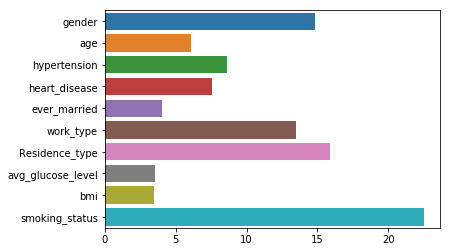

In [73]:
# Feature importance

feature_importances = model.get_feature_importance()
feature_names = xtrain.columns
sbn.barplot(feature_importances,feature_names)

In [74]:
print(roc_auc_score(pred17,ytest))
print(roc_auc_score(pred15,ytest))
print(roc_auc_score(pred13,ytest))
print(roc_auc_score(pred3,ytest))

0.9889774602262458
0.9875559955582636
0.9881470497964712
0.9885746450532962


In [75]:
print(f1_score(pred17,ytest))
print(f1_score(pred15,ytest))
print(f1_score(pred13,ytest))
print(f1_score(pred3,ytest))

0.9820253413220704
0.9805729984301412
0.9825109916951636
0.9816396661757486


Text(0.5,1,'ROC AUC Score')

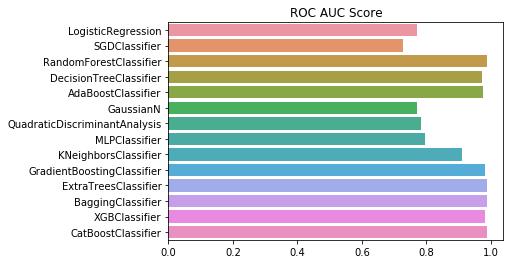

In [76]:
# roc_auc_score
sbn.barplot(d,n).set_title("ROC AUC Score")

Text(0.5,1,'F-1 Score')

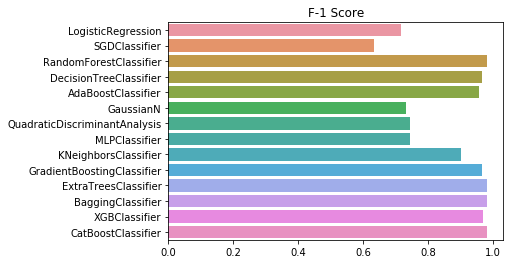

In [77]:
# f-1 score
sbn.barplot(f,n).set_title("F-1 Score")

Text(0.5,1,'Precision')

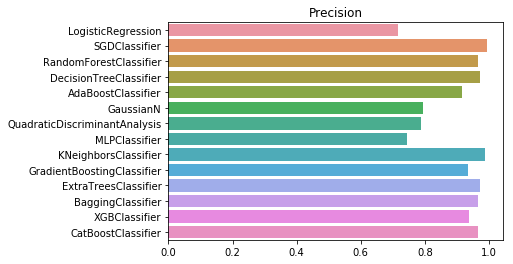

In [78]:
# precision
sbn.barplot(p,n).set_title("Precision")

Text(0.5,1,'Recall')

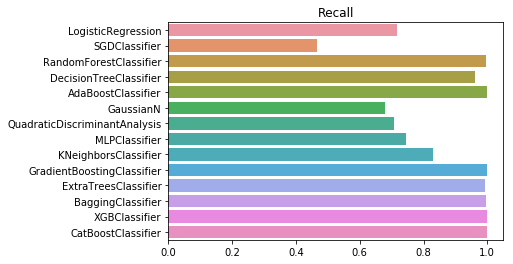

In [79]:
# recall
sbn.barplot(r,n).set_title("Recall")

Text(0.5,1,'Time Taken')

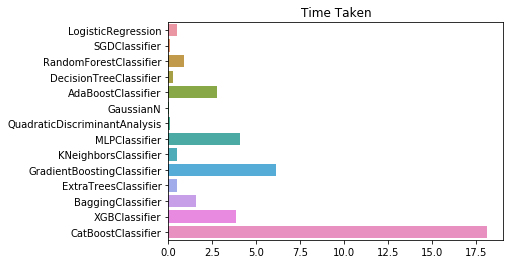

In [80]:
sbn.barplot(t,n).set_title("Time Taken")